Transfer learning para classificação de animais com o modelo microsoft/Florence-2-large

In [1]:
from torch import torch, nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Load model

In [2]:
base_model = models.efficientnet_b0(pretrained=True)

c:\Users\Gustavo\Documents\Projects\Animals-classify-pytorch\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gustavo\Documents\Projects\Animals-classify-pytorch\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
for param in base_model.parameters():
    param.requires_grad = False

In [4]:
for name, param in base_model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

features.0.0.weight: requires_grad=False
features.0.1.weight: requires_grad=False
features.0.1.bias: requires_grad=False
features.1.0.block.0.0.weight: requires_grad=False
features.1.0.block.0.1.weight: requires_grad=False
features.1.0.block.0.1.bias: requires_grad=False
features.1.0.block.1.fc1.weight: requires_grad=False
features.1.0.block.1.fc1.bias: requires_grad=False
features.1.0.block.1.fc2.weight: requires_grad=False
features.1.0.block.1.fc2.bias: requires_grad=False
features.1.0.block.2.0.weight: requires_grad=False
features.1.0.block.2.1.weight: requires_grad=False
features.1.0.block.2.1.bias: requires_grad=False
features.2.0.block.0.0.weight: requires_grad=False
features.2.0.block.0.1.weight: requires_grad=False
features.2.0.block.0.1.bias: requires_grad=False
features.2.0.block.1.0.weight: requires_grad=False
features.2.0.block.1.1.weight: requires_grad=False
features.2.0.block.1.1.bias: requires_grad=False
features.2.0.block.2.fc1.weight: requires_grad=False
features.2.0.b

In [5]:
num_classes = 10

class ModelClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
print(base_model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [7]:
base_model.classifier[1] = ModelClassifier(base_model.classifier[1].in_features, num_classes)

In [8]:
print(base_model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): ModelClassifier(
    (fc1): Linear(in_features=1280, out_features=512, bias=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
    (fc2): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Load and Transform Dataset

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder("dataset", transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32)

In [11]:
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [12]:
image = Image.open('dataset/butterfly/e030b20a20e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg').convert("RGB")

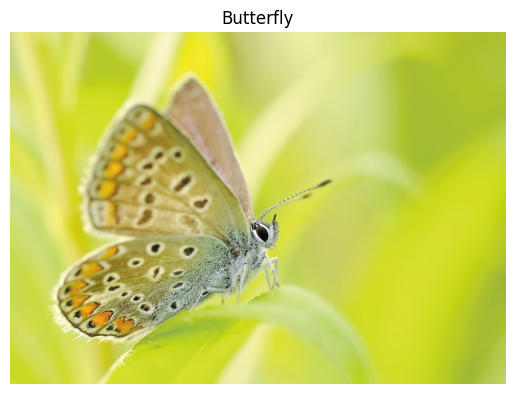

In [13]:
plt.imshow(image)
plt.axis('off')
plt.title("Butterfly")
plt.show()

## Train model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

optimizer = optim.AdamW(base_model.classifier.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 5

for epoch in range(EPOCHS):
    base_model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        outputs = base_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1/5: 100%|██████████| 655/655 [13:27<00:00,  1.23s/it, loss=0.154]


Epoch 1, Loss: 0.7443781785951316


Epoch 2/5: 100%|██████████| 655/655 [12:53<00:00,  1.18s/it, loss=0.606] 


Epoch 2, Loss: 0.290400709769198


Epoch 3/5: 100%|██████████| 655/655 [14:09<00:00,  1.30s/it, loss=0.415] 


Epoch 3, Loss: 0.25124148973868093


Epoch 4/5: 100%|██████████| 655/655 [12:04<00:00,  1.11s/it, loss=0.046] 


Epoch 4, Loss: 0.22915208165939072


Epoch 5/5: 100%|██████████| 655/655 [21:40:11<00:00, 119.10s/it, loss=1.08]        

Epoch 5, Loss: 0.22515461656428476


In [16]:
base_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = base_model(images)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {acc:.2f}")

Validation Accuracy: 0.95


In [19]:
torch.save(base_model.state_dict(), "models/florence_animals_V1.pt")